In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from logistic_regression import LogisticRegression
from softmax_regression import SoftmaxRegression
%matplotlib inline

### Read the iris dataset

There are totally 150 samples.
+: 100
-: 50


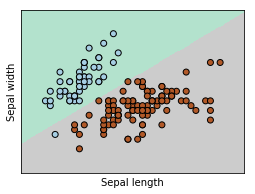

In [2]:
iris = datasets.load_iris()
X = iris.data[:, :2] # use only the first two features
Y = iris.target
n_samples = iris.data.shape[0]
Y[Y == 2] = 1 # change to a 2-class problem


def show_label_partition(Y):
    print("There are totally {} samples.".format(len(Y)))
    print("+:", np.sum(Y==1))
    print("-:", np.sum(Y==0))

def fit_plot(X, Y, fit_classifier=None):
    h = .02 # mesh step size
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    if fit_classifier:
        # we create an instance of Neighbours Classifier and fit the data.
        fit_classifier.fit(X, Y)
        Z = fit_classifier.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.figure(1, figsize=(4, 3))
        plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Pastel2)
    
    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

    plt.show()

show_label_partition(Y)
fit_plot(X, Y, fit_classifier=SoftmaxRegression(l2=1e-5, epochs=100))

### Transferring to PU

 - sample 50% of +, the left becomes P
 - flip sampled + to -
 - join flipped + with - as U

In [383]:
np.random.seed(42)
flip = np.random.rand(n_samples)
Y_pu = Y.copy()
Y_pu[(Y == 1) & (flip < 0.5)] = 0
show_label_partition(Y_pu)

There are totally 150 samples.
+: 48
-: 102


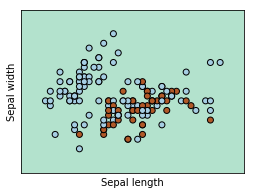

Loss: 0.312580342536


In [552]:
np.random.seed(None)
softreg = SoftmaxRegression(eta=1e-5, l2=1e-5,
                            epochs=200,
                            random_seed=12)
fit_plot(X, Y_pu, fit_classifier=softreg)
print("Loss:", softreg.cost_[-1])

### Asymmetric Softmax Loss

In [477]:
class AsymmetricSoftmaxRegression(SoftmaxRegression):
    def __init__(self, betas, eta=0.01, epochs=100,
                 l2=0.0,
                 minibatches=1,
                 n_classes=None,
                 random_seed=None):
        super(AsymmetricSoftmaxRegression, self).__init__(eta, epochs,
                                                         l2, minibatches,
                                                         n_classes,
                                                         random_seed)
        self._betas = np.array(betas)

    def _cost(self, prob, y_enc):
        cross_entropy = self._cross_entropy(prob, y_enc)
        betas = self._get_betas(y_enc)
        loss = betas * cross_entropy
        loss = np.sum(loss, axis=1)
        L2_term = self.l2 * np.sum(self.w_ ** 2)
        loss = loss + L2_term
        return 0.5 * np.mean(loss)
    
    def _diff(self, softm, y_enc):
        betas = self._get_betas(y_enc)
        return betas * (softm - y_enc)

    def _get_betas(self, y_enc):
        r"""Return betas per sample \beta_t of shape (N, C)."""
        label = np.argmax(y_enc, axis=1).astype('int8')
        label = label[:, np.newaxis]
        betas = self._betas[label]
        repeats = [1] * len(label.shape)
        repeats[1] = self.n_classes
        return np.tile(betas, repeats)

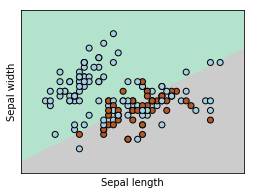

Loss: 0.227936276975


In [549]:
np.random.seed(None)
asym_softreg = AsymmetricSoftmaxRegression(betas=(0.5, 1),
                                           eta=1e-5, l2=1e-5,
                                           random_seed=None)
fit_plot(X, Y_pu, fit_classifier=asym_softreg)
print('Loss:', asym_softreg.cost_[-1])

### HardBootstrapping

In [531]:
class HardBootstrappingSoftmaxRegression(SoftmaxRegression):
    def __init__(self, betas, eta=0.01, epochs=100,
                 l2=0.0,
                 minibatches=1,
                 n_classes=None,
                 random_seed=None):
        super(HardBootstrappingSoftmaxRegression, self).__init__(eta, epochs,
                                                                 l2, minibatches,
                                                                 n_classes,
                                                                 random_seed)
        self._betas = np.array(betas)
        self._betas = self._betas / float(np.max(self._betas))

    def _cost(self, prob, y_enc):
        cross_ent_y = self._cross_entropy(prob, y_enc)
        pred = np.argmax(prob, axis=1)
        pred_enc = self._one_hot(y=pred, n_labels=self.n_classes, dtype=np.int)
        cross_ent_pred = self._cross_entropy(prob, pred_enc)
        betas = self._get_betas(y_enc)
        loss = betas * cross_ent_y + (1 - betas) * cross_ent_pred
        loss = np.sum(loss, axis=1)
        L2_term = self.l2 * np.sum(self.w_ ** 2)
        loss = loss + L2_term
        return 0.5 * np.mean(loss)
    
    def _diff(self, prob, y_enc):
        pred = np.argmax(prob, axis=1)
        pred_enc = self._one_hot(y=pred, n_labels=self.n_classes, dtype=np.int)
        betas = self._get_betas(y_enc)
        return betas * (prob - y_enc) + (1 - betas) * (prob - pred_enc)

    def _get_betas(self, y_enc):
        r"""Return betas per sample \beta_t of shape (N, C)."""
        label = np.argmax(y_enc, axis=1).astype('int8')
        label = label[:, np.newaxis]
        betas = self._betas[label]
        repeats = [1] * len(label.shape)
        repeats[1] = self.n_classes
        return np.tile(betas, repeats)

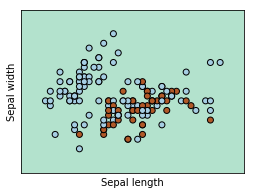

Loss 0.318294874653


In [550]:
np.random.seed(None)
hboot_softreg = HardBootstrappingSoftmaxRegression(betas=(0.5, 1),
                                                   eta=1e-5, l2=1e-5,
                                                   random_seed=None)
fit_plot(X, Y_pu, fit_classifier=hboot_softreg)
print("Loss", hboot_softreg.cost_[-1])